# 13wk-1: 순환신경망 (4) – LSTM 계산과정 재현, LSTM은 왜 강한가?

최규빈  
2024-05-27

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/13wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>



# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-x9DomHaojnXVqjdb0nqd_c&si=sh8nkPmHQb9ofrrL>



# 2. Import

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
soft = torch.nn.Softmax(dim=1)
sig = torch.nn.Sigmoid()
tanh = torch.nn.Tanh()

# 3. Data – `abcabC`

In [3]:
txt = list('abcabC')*50
txt[:10]

['a', 'b', 'c', 'a', 'b', 'C', 'a', 'b', 'c', 'a']

In [4]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

,x,y
0,a,b
1,b,c
2,c,a
3,a,b
4,b,C


In [5]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

# 4. LSTM 계산과정 재현

## A. `torch.nn.LSTMCell`

In [6]:
torch.manual_seed(43052)
lstmcell = torch.nn.LSTMCell(4,2) # 숙성담당.. 4개의 feature를 2차원 임베딩 스페이스로..
cook = torch.nn.Linear(2,4) #4차원 예측을위해 2 -> 4
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)
#---# RNNCell과 비슷한 과정..
L = len(X)
for epoc in range(1):
    # 1~2
    loss = 0
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    for t in range(L):
        Xt,yt = X[t],y[t]
        ht,ct = lstmcell(Xt,(ht,ct)) #ht, ct를 전달해줘야함.. ct까지 만드는게 포인트.. 간장을 두통씩 만든다 생각.
        netout_t = cook(ht)
        loss = loss + loss_fn(netout_t,yt) #ot는 뒤에 쓰이니까 중복을 피하기 위해..
    loss = loss/L
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [7]:
ht,ct

(tensor([0.0533, 0.2075], grad_fn=<SqueezeBackward1>),
 tensor([0.1218, 0.5590], grad_fn=<SqueezeBackward1>))

## B. 직접구현

### ***t=0 $\to$ t=1***

`-` `lstmcell`을 이용하여 $t=0 \to t=1$을 구현해보자. (결과비교용)

In [8]:
torch.manual_seed(43052)
lstmcell = torch.nn.LSTMCell(4,2) # 숙성담당
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(1):
    # 1~2
    loss = 0
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    for t in range(1): #배치에서도 한번만 돌아감
        Xt,yt = X[t],y[t]
        ht,ct = lstmcell(Xt,(ht,ct))
        netout_t = cook(ht)
        loss = loss + loss_fn(netout_t,yt)
    loss = loss/L
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [9]:
ht,ct

(tensor([0.1067, 0.1069], grad_fn=<SqueezeBackward1>),
 tensor([0.1734, 0.2688], grad_fn=<SqueezeBackward1>))

-   이런결과를 어떻게 만드는걸까?
-   <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>

`-` 직접계산
(${\boldsymbol i}_t, {\boldsymbol f}_t, {\boldsymbol g}_t, {\boldsymbol o}_t$)

In [10]:
torch.manual_seed(43052)
lstmcell = torch.nn.LSTMCell(4,2) # 숙성담당, 여기에 ifgo 모든 가중치가 모여있음..

In [11]:
Wih = lstmcell.weight_ih.T #shape = 4,8
Wih02 = Wih[:,0:2]
Wih24 = Wih[:,2:4]
Wih46 = Wih[:,4:6]
Wih68 = Wih[:,6:8]
#--#
Whh = lstmcell.weight_hh.T #shape = 2,8
Whh02 = Whh[:,0:2]
Whh24 = Whh[:,2:4]
Whh46 = Whh[:,4:6]
Whh68 = Whh[:,6:8]
#--#
bih02 = lstmcell.bias_ih[0:2] #shape = 8, 벡터. 각각의 shape = 2
bih24 = lstmcell.bias_ih[2:4]
bih46 = lstmcell.bias_ih[4:6]
bih68 = lstmcell.bias_ih[6:8]
#--#
bhh02 = lstmcell.bias_hh[0:2] #shape = 8, 벡터. 각각의 shape = 2
bhh24 = lstmcell.bias_hh[2:4]
bhh46 = lstmcell.bias_hh[4:6]
bhh68 = lstmcell.bias_hh[6:8]

In [14]:
Wih.shape, Whh.shape

(torch.Size([4, 8]), torch.Size([2, 8]))

In [16]:
lstmcell.bias_ih.shape, lstmcell.bias_hh.shape

(torch.Size([8]), torch.Size([8]))

In [ ]:
ht = torch.zeros(2) #0을 설정하지 않아서 살짝 헤메셨음.. Hidden state
ct = torch.zeros(2) #Cell state
#--# i,f,o는 gate라고 한다..
it = sig(Xt@Wih02 + bih02 + ht@Whh02 + bhh02) #인풋이 얼마만큼 들어올 지 조절(0~1)
ft = sig(Xt@Wih24 + bih24 + ht@Whh24 + bhh24) #forget gate.. 얼마만큼 잊을지..(0이면 완전 잊고 1이면 잊지 않고!)
gt = tanh(Xt@Wih46 + bih46 + ht@Whh46 + bhh46) #얘는 ht와 결이 비슷함.
ot = sig(Xt@Wih68 + bih68 + ht@Whh68 + bhh68)

In [ ]:
it,ft,gt,ot

(tensor([0.3081, 0.5949], grad_fn=<SigmoidBackward0>),
 tensor([0.5065, 0.4264], grad_fn=<SigmoidBackward0>),
 tensor([0.5629, 0.4518], grad_fn=<TanhBackward0>),
 tensor([0.6216, 0.4072], grad_fn=<SigmoidBackward0>))

그런데 아래와 같이 계산할수도 있음.

In [ ]:
ifgo = Xt @ lstmcell.weight_ih.T +  lstmcell.bias_ih\
+ ht @ lstmcell.weight_hh.T +  lstmcell.bias_hh #위와 같은 과정이... 행렬곱으로 대체된 것 뿐..

In [ ]:
print(f"it = {sig(ifgo[0:2])}")
print(f"ft = {sig(ifgo[2:4])}")
print(f"gt = {tanh(ifgo[4:6])}") #애만 tanh..
print(f"ot = {sig(ifgo[6:8])}")

it = tensor([0.3081, 0.5949], grad_fn=<SigmoidBackward0>)
ft = tensor([0.5065, 0.4264], grad_fn=<SigmoidBackward0>)
gt = tensor([0.5629, 0.4518], grad_fn=<TanhBackward0>)
ot = tensor([0.6216, 0.4072], grad_fn=<SigmoidBackward0>)


`-` 직접계산 (${\boldsymbol c}_t, {\boldsymbol h}_t$)

In [ ]:
ct = it*gt + ft*ct
ht = ot*tanh(ct)

In [ ]:
ht,ct

(tensor([0.1067, 0.1069], grad_fn=<MulBackward0>),
 tensor([0.1734, 0.2688], grad_fn=<AddBackward0>))

### `#` ***t=0 $\to$ t=L***

`-` `lstmcell`을 이용하여 구현해보자. (결과비교용)

In [ ]:
torch.manual_seed(43052)
lstmcell = torch.nn.LSTMCell(4,2) # 숙성담당
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(1):
    # 1~2
    loss = 0
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    for t in range(L):
        Xt,yt = X[t],y[t]
        ht,ct = lstmcell(Xt,(ht,ct))
        netout_t = cook(ht)
        loss = loss + loss_fn(netout_t,yt)
    loss = loss/L
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
ht,ct

(tensor([0.0533, 0.2075], grad_fn=<SqueezeBackward1>),
 tensor([0.1218, 0.5590], grad_fn=<SqueezeBackward1>))

`-` 직접구현

In [ ]:
torch.manual_seed(43052)
lstmcell = torch.nn.LSTMCell(4,2) # 숙성담당
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(1):
    # 1~2
    loss = 0
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    for t in range(L):
        Xt,yt = X[t],y[t]
        #ht,ct = lstmcell(Xt,(ht,ct)) 로 한큐에 갈 수 있지만... 직접 계산을 해보자.
        ifgo = Xt @ lstmcell.weight_ih.T +  lstmcell.bias_ih +\
                ht @ lstmcell.weight_hh.T +  lstmcell.bias_hh
        it,ft,gt,ot = sig(ifgo[0:2]),sig(ifgo[2:4]),tanh(ifgo[4:6]),sig(ifgo[6:8])
        ct = it*gt + ft*ct #ct가
        ht = ot*tanh(ct) #ht와 섞인다... ht안에 비선형 패턴이 생긴 ct가 존재..
        netout_t = cook(ht)
        loss = loss + loss_fn(netout_t,yt)
    loss = loss/L
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
ht,ct

(tensor([0.0533, 0.2075], grad_fn=<MulBackward0>),
 tensor([0.1218, 0.5590], grad_fn=<AddBackward0>))

## C. `torch.nn.LSTM`

In [ ]:
torch.manual_seed(43052)
lstmcell = torch.nn.LSTMCell(4,2) # 숙성담당.. 눈치... weight 맞출려고 선언했구먼?
cook = torch.nn.Linear(2,4)
lstm = torch.nn.LSTM(4,2) # <-- 이거로 학습
lstm.weight_ih_l0.data = lstmcell.weight_ih.data
lstm.weight_hh_l0.data = lstmcell.weight_hh.data
lstm.bias_ih_l0.data = lstmcell.bias_ih.data
lstm.bias_hh_l0.data = lstmcell.bias_hh.data

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)
#---#
L = len(X)
Water = torch.zeros(1,2)
for epoc in range(1):
    # 1
    h,(hL,cL) = lstm(X,(Water,Water)) #마지막 간장을 받았던것과 일맥 상통.
    netout = cook(h)
    # 2
    loss = loss_fn(netout,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
hL,cL #마지막값을 띄워주니 좋군..

(tensor([[0.0533, 0.2075]], grad_fn=<SqueezeBackward1>),
 tensor([[0.1218, 0.5590]], grad_fn=<SqueezeBackward1>))

# 5. LSTM은 왜 강한가?

## A. 적합 및 시각화

`-` 적합

In [ ]:
torch.manual_seed(43052)
lstm = torch.nn.LSTM(4,2)
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(cook.parameters()),lr=0.1)
#--#
Water = torch.zeros(1,2)
for epoc in range(200):
    ## step1
    h, (hL,cL) = lstm(X,(Water,Water))
    netout = cook(h)
    ## step2
    loss = loss_fn(netout,y)
    ## step3
    loss.backward()
    ## step4
    optimizr.step()
    optimizr.zero_grad()

`-` 시각화

In [ ]:
L = len(X)
i = input_gate = torch.zeros(L,2)
f = forget_gate = torch.zeros(L,2)
g = gidden_state = torch.zeros(L,2)
o = output_gate = torch.zeros(L,2)
c = cell_state = torch.zeros(L,2)
h = hidden_state = torch.zeros(L,2)
#--#
water = torch.zeros(2)
ifgo = X[0] @ lstm.weight_ih_l0.T + lstm.bias_ih_l0 +\
        water @ lstm.weight_hh_l0.T + lstm.bias_hh_l0
# 위에서 water는 h0에 대응
i[0] = sig(ifgo[0:2])
f[0] = sig(ifgo[2:4])
g[0] = tanh(ifgo[4:6])
o[0] = sig(ifgo[6:8])
c[0] = f[0] * water + i[0] * g[0] # water는 c0에 대응
h[0] = o[0] * tanh(c[0])
#--#
for t in range(1,L):
    ## 1: calculate ifgo
    ifgo = X[t] @ lstm.weight_ih_l0.T + lstm.bias_ih_l0 +\
            h[t-1] @ lstm.weight_hh_l0.T +  lstm.bias_hh_l0
    ## 2: decompose ifgo
    i[t] = sig(ifgo[0:2])
    f[t] = sig(ifgo[2:4])
    g[t] = tanh(ifgo[4:6])
    o[t] = sig(ifgo[6:8])
    ## 3: calculate ht,ct
    c[t] = f[t] * c[t-1] + i[t] * g[t]
    h[t] = o[t] * tanh(c[t])

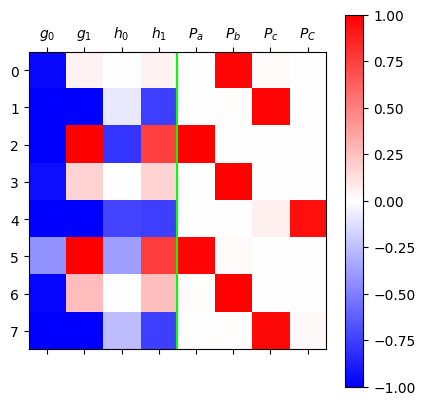

In [ ]:
mat = torch.concat([g,h,soft(netout)],axis=1)[:8].data
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1);
plt.axvline(x=3.5,color="lime")
plt.xticks(
    ticks=range(mat.shape[-1]),
    labels=[r"$g_0$",r"$g_1$",r"$h_0$",r"$h_1$",
            r"$P_a$",r"$P_b$",r"$P_c$",r"$P_C$"]
)
plt.colorbar() #LSTM이 잘 구분하는 이유? hidden state가 -1과 1사이의 적절한 다양한 값이 나오기 때문..
#왜 다양한가? -> 따져봐야함.

ht에 gt가 약간 남아있는 경우가 있음\
RNN은 g 에서 바로 yhat으로 쏘는 경우(정의된 형태가 exactly same)\
LSTM은 g -> h -> yhat 으로 쏨..문맥을 잘 학습하기 위해 희석,보존을 적절히 수행

## B. 시각화1: $({\boldsymbol g}_t, {\boldsymbol c}_{t-1})$ $\to {\boldsymbol c}_{t}$

In [ ]:
mat1 = torch.concat([g[1:9],i[1:9],g[1:9]*i[1:9]],axis=1).data
mat2 = torch.concat([c[:8],f[1:9],c[:8]*f[1:9]],axis=1).data
mat3 = torch.concat([g[1:9]*i[1:9],c[:8]*f[1:9],c[1:9]],axis=1).data

In [ ]:
c[:8].min(),c[:8].max()

(tensor(-1.0900, grad_fn=<MinBackward1>),
 tensor(0.9979, grad_fn=<MaxBackward1>))

-   ${\boldsymbol c}_t$의 경우 원래 출력값이 -1, 1 사이라는 보장은
    없으나, 이 예제의 경우에는 거의 -1, 1 사이임.
-   `matshow`로 시각화할때 `vmin=-1`, `vmax=1`로 설정해도
    ${\boldsymbol c}_t$를 표현함에 부족함이 없을듯

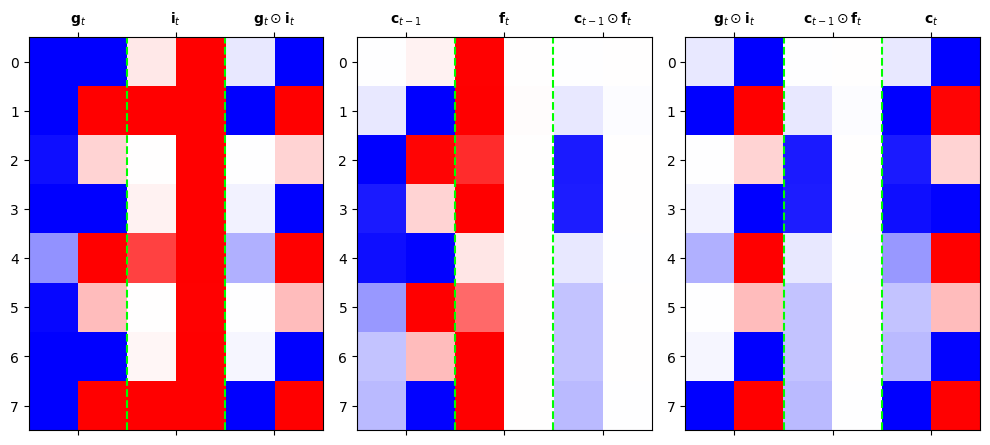

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].matshow(mat1,cmap='bwr',vmin=-1,vmax=1);
ax[0].axvline(x=1.5,linestyle="dashed",color="lime")
ax[0].axvline(x=3.5,linestyle="dashed",color="lime")
ax[0].set_xticks(ticks= [0.5,2.5,4.5],labels=[r'${\bf g}_t$',r'${\bf i}_t$',r'${\bf g}_t \odot {\bf i}_t$']);
ax[1].matshow(mat2,cmap='bwr',vmin=-1,vmax=1);
ax[1].axvline(x=1.5,linestyle="dashed",color="lime")
ax[1].axvline(x=3.5,linestyle="dashed",color="lime")
ax[1].set_xticks(ticks= [0.5,2.5,4.5],labels=[r'${\bf c}_{t-1}$',r'${\bf f}_t$',r'${\bf c}_{t-1} \odot {\bf f}_t$']);
ax[2].matshow(mat3,cmap='bwr',vmin=-1,vmax=1);
ax[2].axvline(x=1.5,linestyle="dashed",color="lime")
ax[2].axvline(x=3.5,linestyle="dashed",color="lime")
ax[2].set_xticks(ticks= [0.5,2.5,4.5],labels=[r'${\bf g}_t \odot {\bf i}_t$',r'${\bf c}_{t-1} \odot {\bf f}_t$',r'${\bf c}_t$']);
fig.tight_layout()

I가 찐할수록 g가 그대로 넘어감.\
i가 하얀색인 부분은 색이 안넘어감 (넘어간 결과가 하얀색)

f는 두번째 줄이 다 하얀색임... (중첩해서 거르지 않겠다는 건가..)\
gt는 현재의 정보, ct-1는 과거의 정보를 담당\
얼마만큼 잊고 얼마만큼 킵할건데? -> 학습해야함

`-` ${\boldsymbol g}_t$ 특징: 보통 -1,1 중 하나의 값을 가지도록 학습되어
있다. (마치 RNN의 hidden node처럼!)

-   $\boldsymbol{g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg}+ {\boldsymbol b}_{ig}+{\boldsymbol b}_{hg})$

`-` ${\boldsymbol c}_t$ 특징: ${\boldsymbol g}_t$와 매우 비슷하지만 약간
다른값을 가진다. 그래서 ${\boldsymbol g}_t$와는 달리 -1,1 이외의 값도
종종 등장.

-   ${\boldsymbol c}_t$의 값은 이론상 제한이 없음. (꼭 -1,1 사이에 있지
    않음)

## C. 시각화2: ${\boldsymbol g}_t \to {\boldsymbol h}_{t}$

In [ ]:
mat = torch.concat([g[:8],tanh(c[:8]),o[:8],h[:8]],axis=1).data

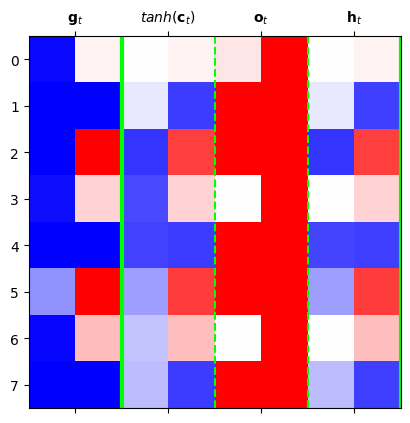

In [ ]:
plt.matshow(mat.data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks([0.5,2.5,4.5,6.5],[r'${\bf g}_t$',r'$tanh({\bf c}_t)$',r'${\bf o}_t$',r'${\bf h}_t$']);
plt.axvline(x=1.5,color="lime",linewidth=3)
plt.axvline(x=3.5,linestyle="dashed",color="lime")
plt.axvline(x=5.5,linestyle="dashed",color="lime")
plt.axvline(x=7.5,color="lime",linewidth=3)

아웃풋 게이트도 색이 진할 수록 그대로 통과시킨다.\
tanh(ct) -> ot -> ht

`-` ${\boldsymbol h}_t$ 특징: (1) ${\boldsymbol c}_t$에서 원하는 것만
선택적으로 특징으로 삼은 느낌. (2) $c_t$보다 훨씬 값을 다양하게 가진다.
($\odot$ 의 효과 )

## D. LSTM의 알고리즘 리뷰 I (수식위주)

**(step1)** calculate ${\tt ifgo}$

${\tt ifgo} = {\boldsymbol x}_t  \big[{\bf W}_{ii} | {\bf W}_{if}| {\bf W}_{ig} |{\bf W}_{io}\big] + {\boldsymbol h}_{t-1}  \big[ {\bf W}_{hi}|{\bf W}_{hf} |{\bf W}_{hg} | {\bf W}_{ho} \big] + bias$

$=\big[{\boldsymbol x}_t{\bf W}_{ii} + {\boldsymbol h}_{t-1}{\bf W}_{hi} ~\big|~ {\boldsymbol x}_t{\bf W}_{if}+ {\boldsymbol h}_{t-1}{\bf W}_{hf}~ \big|~ {\boldsymbol x}_t{\bf W}_{ig} + {\boldsymbol h}_{t-1}{\bf W}_{hg}  ~\big|~ {\boldsymbol x}_t{\bf W}_{io} + {\boldsymbol h}_{t-1}{\bf W}_{ho} \big] + bias$

참고: 위의 수식은 아래코드에 해당하는 부분

``` python
ifgo = Xt @ lstm_cell.weight_ih.T +\
       ht @ lstm_cell.weight_hh.T +\
       lstm_cell.bias_ih + lstm_cell.bias_hh
```

**(step2)** decompose ${\tt ifgo}$ and get ${\boldsymbol i}_t$,
${\boldsymbol f}_t$, ${\boldsymbol g}_t$, ${\boldsymbol o}_t$

${\boldsymbol i}_t = \sigma({\boldsymbol x}_t {\bf W}_{ii} + {\boldsymbol h}_{t-1} {\bf W}_{hi} +bias )$

${\boldsymbol f}_t = \sigma({\boldsymbol x}_t {\bf W}_{if} + {\boldsymbol h}_{t-1} {\bf W}_{hf} +bias )$

${\boldsymbol g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg} +bias )$

${\boldsymbol o}_t = \sigma({\boldsymbol x}_t {\bf W}_{io} + {\boldsymbol h}_{t-1} {\bf W}_{ho} +bias )$

**(step3)** calculate ${\boldsymbol c}_t$ and ${\boldsymbol h}_t$

${\boldsymbol c}_t = {\boldsymbol i}_t \odot {\boldsymbol g}_t+ {\boldsymbol f}_t \odot {\boldsymbol c}_{t-1}$

${\boldsymbol h}_t = {\boldsymbol o}_t \odot \tanh({\boldsymbol c}_t)$

## E. LSTM의 알고리즘 리뷰 II (느낌위주)

-   이해 및 암기를 돕기위해서 비유적으로 설명한 챕터입니다..

`-` 느낌: RNN이 콩물에서 간장을 한번에 숙성시키는 방법이라면 LSTM은
콩물에서 간장을 단계를 나누어 숙성하는 느낌이다.

-   RNN:
   ${\boldsymbol x}_t \overset{{\boldsymbol h}_{t-1}}{\longrightarrow} {\boldsymbol h}_t$
-   LSTM:
  ${\boldsymbol x}_t \overset{{\boldsymbol h}_{t-1}}{\longrightarrow} {\boldsymbol g}_t \overset{{\boldsymbol c}_{t-1}}{\longrightarrow} \Big({\boldsymbol c}_t \to {\boldsymbol h}_t \Big)$

`-` ${\boldsymbol g}_t$에 대하여

-   과거와 현재의 결합 (선형변환): ${\boldsymbol x}_t$와
  ${\boldsymbol h}_{t-1}$를 ${\bf W}_{ig}, {\bf W}_{hg}$를 이용해
    선형결합
-   숙성(비선형변환): $\tanh$
-   느낌: RNN에서 간장을 만들던 그 수식에서 $h_t$를 $g_t$로 바꾼것
    그래서 RNN의 간장과 비슷하다고 생각하면 된다.
-   노트: RNN의 간장은 한계를 가지고 있는데 그 한계를 극복하기 위해 만든
  것이 ${\boldsymbol c}_t$

`-` ${\boldsymbol c}_t$에 대하여

-   과거와 현재의 결합 (선형변환): ${\boldsymbol g}_{t}$와
  ${\boldsymbol c}_{t-1}$를 요소별로 선택하고 더하는 과정
-   숙성 (비선형변환): 없음.
-   느낌: 과거와 현재의 정보중 유리한것만 기억하여 선택적으로 결합함.
  이때 결합방식에 대한 노하우는 ${\tt input-gate}$,
   ${\tt forget-gate}$ 에 있으며 그러한 결합의 결과가
   ${\boldsymbol c}_t$에 있음. 이 ${\boldsymbol c}_t$에 대한 정보는
    그대로 “냉동보관(?)”되어 다음세대로 내려옴.
-   비고: ${\boldsymbol c}_t$는 사실상 LSTM 알고리즘의 꽃이라 할 수
    있음. LSTM은 long short term memory의 약자임. 기존의 RNN은
    장기기억을 활용함에 약점이 있는데 LSTM은 단기기억/장기기억 모두 잘
    활용함. LSTM이 장기기억을 잘 활용하는 비법은 바로
   ${\boldsymbol c}_t$에 있다.

`-` ${\boldsymbol h}_t$에 대하여

-   과거와 현재의 결합 (선형변환): 없음
-   숙성 (비선형변환): $\tanh({\boldsymbol c}_t)$를 요소별로 선택하여
    숙성

> RNN은 기억할 과거정보가 ${\boldsymbol h}_{t-1}$ 하나이지만 LSTM은
> ${\boldsymbol c}_{t-1}$, ${\boldsymbol h}_{t-1}$ 2개이다.

## F. LSTM이 강한이유

`-` 답변1: LSTM이 장기기억에 유리함. 그 이유는 input, forget, output
gate 들이 장기기억을 위한 역할을 하기 때문.

-   비판: 아키텍처에 대한 이론적 근거는 없음. 장기기억을 위하여 꼭
    LSTM같은 구조일 필요는 없음. (게이트는 꼭3개이어야 하는지?)

`-` 답변2: 아키텍처상으로 LSTM은 RNN을 포함함. 그래서 이론적으로 LSTM의
성능이 RNN보다 떨어질 이유는 없음.

`-` 답변3: 저는 사실 아까 살펴본 아래의 이유로 이해하고 있습니다.

-   실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
-   그 이유: RNN은 ${\boldsymbol h}_t$의 값이 -1 혹은 1로 결정되는
   경우가 많았음. 그러나 경우에 따라서는 ${\boldsymbol h}_t$이 -1~1의
    값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한
    방식으로 학습되는 경우가 많았음.
-   왜 LSTM의 ${\boldsymbol h}_t$은 -1,1 이외의 값을 쉽게 가질 수
  있는가? $\odot$ 때문에.. 즉 게이트때문에..

# 6. Ref

`-` 참고자료들

-   <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
-   <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>
-   <https://arxiv.org/abs/1402.1128>